  # <center> ANALYSIS LOS ANGELES CRIME FROM 2020 TO PRESENT <center>

  **Team Members:**

  **Full Name** | **ID Number** | **Github**
  --- | --- | ---
  Nguyễn Phương Nam | 21120504 | https://github.com/Mr-Phuong-Nam
  Võ Bá Hoàng Nhất | 21120516 | https://github.com/NhatUS03
  Nguyễn Gia Phúc | 21120529 | https://github.com/ngphucdotpy



  ---

  ### Import libraries

In [4]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

import os 
import sys

import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

from lightgbm import LGBMClassifier

In [5]:
pd.set_option('display.max_columns', 500)


  ---

  # 1. Data collection

  - What subject is your data about? What is the source of your data?
      - Our data is about crime, **detailedly** this dataset reflects incidents of crime in the City of Los Angeles from 2020 to now.
      - The source of dataset is https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8/about_data
      - It has all the crimes reported and recorded by Los Angeles Police Department (LAPD).
  - Do authors of this data allow you to use like this?
      - Authors of this data allow everyone use like, which based on CC0: Public Domain (No copyright), so we can collect, modify and distribute this dataset.
  - For ease of use, our team relies on the data downloaded from Kaggle, available at https://www.kaggle.com/datasets/ishmaelkiptoo/usa-los-angeles-crimes-data-2020-to-2023/data. This choice is motivated by the instability of the original source, where recent updates have resulted in inconsistencies in the data.
- How did the author on Kaggle collect the data?
    - The data source offers various methods for data collection, including API, CSV, JSON, RDF, RSS, XLS, XLSX, XML, and ZIP. We have the flexibility to select any preferred method for collecting the data.

  # 2. Exploring data

  ## 2.1. Load the data

In [6]:
crime_df = pd.read_csv('../Data/Crime_Data_from_2020_to_Present.csv')
crime_df.head()


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,0444 0913,36,F,B,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,0416 1822 1414,25,M,H,102.0,SIDEWALK,500.0,UNKNOWN WEAPON/OTHER WEAPON,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,1501,0,X,X,726.0,POLICE FACILITY,NaN,NaN,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329 1402,76,F,W,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329,31,X,X,409.0,BEAUTY SUPPLY STORE,NaN,NaN,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


 Normallizing the column names

In [7]:
#Lowercase all columns and replace spaces and "-" with underscores
crime_df.columns = crime_df.columns.str.lower()
crime_df.columns = crime_df.columns.str.replace(' ', '_')
crime_df.columns= crime_df.columns.str.replace('-', '_')

  ## 2.2 General

  ### How many rows and how many columns

In [8]:
crime_df.shape

(829778, 28)

  ### What is the meaning of each row?
  Each row reflects a crime incident that occurred at a specific time and location in Los Angeles from 2020 to the present.

  ### Are there duplicated rows?

In [9]:
is_duplicated = np.any(crime_df.duplicated())
is_duplicated

False

  ### The meaning of each column

  - ``` dr_no ```: Unique identification number for each reported crime.
  - ``` date_rptd ```: The date when the crime was reported.
  - ``` date_occ ```: The date when the crime occurred.
  - ``` time_occ ```: The time when the crime occurred.
  - ``` area ```: The Los Angeles Police Department (LAPD) has 21 Community Police Stations referred to as Geographic Areas within the department. These Geographic Areas are sequentially numbered from 1-21.
  - ``` area_name ```: The 21 Geographic Areas or Patrol Divisions are also given a name designation that references a landmark or the surrounding community that it is responsible for. For example 77th Street Division is located at the intersection of South Broadway and 77th Street, serving neighborhoods in South Los Angeles.
  - ```rpt_dist_no``` : A four-digit code that represents a sub-area within a Geographic Area. All crime records reference the "RD" that it occurred in for statistical comparisons. Find LAPD Reporting Districts on the LA City GeoHub at http://geohub.lacity.org/datasets/c4f83909b81d4786aa8ba8a74
  - ```part_1_2```: The code that categories the crime.
      - 1 for part I crimes: also known as "Serious Crimes". Divided into two main categories:
          - Violent Crimes: Offenses involving force or threat of force. Examples include murder, rape, robbery, and aggravated assault.
          - Property Crimes: Offenses involving the taking or destruction of property but not force or threat of force. Examples include burglary, larceny-theft, motor vehicle theft, and arson.
      - 2 for part II crimes: also known as "Less Serious Crimes". Examples include simple assault, fraud, embezzlement, drug offenses, and vandalism.
  - ```crm_cd```: The crime code, representing the type of crime.
  - ```crm_cd_desc```: The description of the crime.
  - ```mocodes```: Modus Operandi (MO) codes, which describe the method or pattern of operation used by the offender
  - ```vict_age```: The age of the victim.
  - ```vict_sex```: The gender of the victim (F: Female, M: Male, X: Unknown)
  - ```vict_descent```: Descent Code:
      - A - Other Asian
      - B - Black
      - C - Chinese
      - D - Cambodian
      - F - Filipino
      - G - Guamanian
      - H - Hispanic/Latin/Mexican
      - I - American Indian/Alaskan Native
      - J - Japanese
      - K - Korean
      - L - Laotian
      - O - Other
      - P - Pacific Islander
      - S - Samoan
      - U - Hawaiian
      - V - Vietnamese
      - W - White
      - X - Unknown
      - Z - Asian Indian
  - ```premis_cd```: The type of structure, vehicle, or location where the crime took place.
  - ```premis_desc```: Defines the Premise Code provided.
  - ```weapon_used_cd```: The weapon code, representing the type of weapon used in the crime
  - ```weapon_desc```: Defines the Weapon Used Code provided.
  - ```status```: The status of the reported crime.
  - ```status_desc```: Defines the Status Code provided.
      - AO: Adult Other
      - AA: Adult Arrest
      - IC: Invest Cont
      - JA: Juv Arrest
      - JO: Juv Other
      - CC: Unknown
  - ```crm_cd_1```: Additional crime code information
  - ```crm_cd_2```: Additional crime code information
  - ```crm_cd_3```: Additional crime code information
  - ```crm_cd_4```: Additional crime code information
  - ```location```: The location where the crime took place.
  - ```cross_street```: The cross street where the crime took place.
  - ```lat```: The latitude of the location
  - ```lon```: The longitude of the location

  ### General information about each column

In [10]:
crime_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829778 entries, 0 to 829777
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dr_no           829778 non-null  int64  
 1   date_rptd       829778 non-null  object 
 2   date_occ        829778 non-null  object 
 3   time_occ        829778 non-null  int64  
 4   area            829778 non-null  int64  
 5   area_name       829778 non-null  object 
 6   rpt_dist_no     829778 non-null  int64  
 7   part_1_2        829778 non-null  int64  
 8   crm_cd          829778 non-null  int64  
 9   crm_cd_desc     829778 non-null  object 
 10  mocodes         714922 non-null  object 
 11  vict_age        829778 non-null  int64  
 12  vict_sex        720479 non-null  object 
 13  vict_descent    720471 non-null  object 
 14  premis_cd       829768 non-null  float64
 15  premis_desc     829286 non-null  object 
 16  weapon_used_cd  289319 non-null  float64
 17  weapon_des

  Some columns have the wrong data type:
  - ```date_rptd```: object -> datetime
  - ```date_occ```: object -> datetime
  - ```time_occ```: int -> datetime
  - ```mocodes```: object -> list of mocodes

  crm_cd 2, 3, 4 have a lot of missing values

 ## 2.3 Exploring numerical and categorical columns

 Select the numerical and categorical columns.

In [11]:
num_cols = ['vict_age', 'lat', 'lon']

cat_cols = ['area', 'area_name', 'part_1_2', 'crm_cd', 'crm_cd_desc', 'mocodes', 'vict_sex', 'vict_descent', 'premis_cd', 'premis_desc', 'weapon_used_cd', 'weapon_desc', 'status', 'status_desc', 'crm_cd_1', 'crm_cd_2', 'crm_cd_3', 'crm_cd_4', 'cross_street']


 ### Numerical columns

In [12]:
crime_df[num_cols].isnull().mean() * 100


vict_age    0.0
lat         0.0
lon         0.0
dtype: float64

 These columns have no missing values.

In [13]:
crime_df[num_cols].agg(['min', 'max'])


,vict_age,lat,lon
min,-3,0.0000,-118.6676
max,120,34.3343,0.0000


- The `vict_age` value is unusual. It includes negative ages (-3) and exceptionally high values (120), suggesting inconsistencies or potential errors.
- The `lat` and `lon` values exhibit an anomaly, encompassing zero values that correspond to a location distant from Los Angeles.

 ### Categorical columns

In [14]:
crime_df[cat_cols].isnull().mean() * 100


area               0.000000
area_name          0.000000
part_1_2           0.000000
crm_cd             0.000000
crm_cd_desc        0.000000
mocodes           13.841775
vict_sex          13.172077
vict_descent      13.173041
premis_cd          0.001205
premis_desc        0.059293
weapon_used_cd    65.132963
weapon_desc       65.132963
status             0.000000
status_desc        0.000000
crm_cd_1           0.001205
crm_cd_2          92.645262
crm_cd_3          99.751982
crm_cd_4          99.992649
cross_street      84.030909
dtype: float64

  The overall missing value ratios are low except `weapon_used_cd`, `weapon_desc`, `crm_cd_2`, `crm_cd_3`, `crm_cd_4` and `cross_street`.

In [15]:
crime_df[cat_cols].nunique()


area                  21
area_name             21
part_1_2               2
crm_cd               138
crm_cd_desc          138
mocodes           276670
vict_sex               5
vict_descent          20
premis_cd            313
premis_desc          306
weapon_used_cd        79
weapon_desc           79
status                 6
status_desc            6
crm_cd_1             140
crm_cd_2             123
crm_cd_3              37
crm_cd_4               6
cross_street        9731
dtype: int64

   The `mocodes` column may contain combinations of Mocodes, leading to a high number of unique values. However, the overall number of unique values in the other columns is within a normal range.

In [16]:
crime_df['mocodes'].str.split().explode().nunique()


728

 `mocodes`' unique values after splitting are shown above.

In [17]:
for col in cat_cols:
    print('-', col, ': ', end = '')
    print(crime_df[col].dropna().unique()[:5])


- area : [ 3  1 15 19 17]
- area_name : ['Southwest' 'Central' 'N Hollywood' 'Mission' 'Devonshire']
- part_1_2 : [2 1]
- crm_cd : [624 845 745 740 121]
- crm_cd_desc : ['BATTERY - SIMPLE ASSAULT' 'SEX OFFENDER REGISTRANT OUT OF COMPLIANCE'
 'VANDALISM - MISDEAMEANOR ($399 OR UNDER)'
 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)'
 'RAPE, FORCIBLE']
- mocodes : ['0444 0913' '0416 1822 1414' '1501' '0329 1402' '0329']
- vict_sex : ['F' 'M' 'X' 'H' '-']
- vict_descent : ['B' 'H' 'X' 'W' 'A']
- premis_cd : [501. 102. 726. 502. 409.]
- premis_desc : ['SINGLE FAMILY DWELLING' 'SIDEWALK' 'POLICE FACILITY'
 'MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)' 'BEAUTY SUPPLY STORE']
- weapon_used_cd : [400. 500. 306. 511. 204.]
- weapon_desc : ['STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)'
 'UNKNOWN WEAPON/OTHER WEAPON' 'ROCK/THROWN OBJECT' 'VERBAL THREAT'
 'FOLDING KNIFE']
- status : ['AO' 'IC' 'AA' 'JA' 'JO']
- status_desc : ['Adult Other' 'Invest Cont' 'Adult Arrest' 'Juv Arrest' 'J

   Some unique values of these categorical columns are shown above. All appear normal except for the `mocodes` column, which requires splitting into a list of individual Mocodes during the data pre-processing phase.

# 3. Data cleaning

### 3.1. Drop columns

- Columns `crm_cd_2`, `crm_cd_3`, `crm_cd_4`, `cross_street` are dropped because they have too many missing values.

In [18]:
crime_df = crime_df.drop(columns=['crm_cd_2', 'crm_cd_3', 'crm_cd_4', 'cross_street'])


-  Drop `dr_no`, `area`, `premis_cd`, `status`, `weapon_used_cd` because they are not useful for our analysis.

In [19]:
crime_df = crime_df.drop(['dr_no', 'area', 'premis_cd', 'status', 'weapon_used_cd'], axis=1)


### 3.2. Convert `date_rptd,` `date_occ`, `time_occ` to datetime

-   `date_rptd` and `date_occ` are floating timestamp data. They are something like this: 2020-01-08T00:00:00.000.

-   We only need the date in the front, the time is always 00:00:00.000 so we can drop it.

In [20]:
def convert_to_datetime(col):
    """
    Converts a column with format like '2020-01-01T00:00:00.000' to datetime
    
    Parameters
    ----------
    col : string series

    Returns
    -------
    date series
    """

    return pd.to_datetime(col.str.split('T').str[0])

crime_df['date_occ'] = convert_to_datetime(crime_df['date_occ'])
crime_df['date_rptd'] = convert_to_datetime(crime_df['date_rptd'])



- The `time_occ` column is in integer format. First, we convert it to string format by adding zeros to the left of the number. Then, we convert it to datetime format.

In [21]:
crime_df['time_occ'] = crime_df['time_occ'].astype(str).str.zfill(4)


-   Then we combine `date_occ` and `time_occ` to create a new column `datetime_occ`.

In [22]:
crime_df['datetime_occ'] = pd.to_datetime(crime_df['date_occ'].astype(str) + ' ' + crime_df['time_occ'].astype(str), format='%Y-%m-%d %H%M', errors='coerce')

crime_df[['date_occ', 'time_occ', 'datetime_occ']].head()



,date_occ,time_occ,datetime_occ
0,2020-01-08,2230,2020-01-08 22:30:00
1,2020-01-01,0330,2020-01-01 03:30:00
2,2020-02-13,1200,2020-02-13 12:00:00
3,2020-01-01,1730,2020-01-01 17:30:00
4,2020-01-01,0415,2020-01-01 04:15:00


-  Now we can drop `date_occ`, `time_occ`.

In [23]:
crime_df = crime_df.drop(['date_occ', 'time_occ'], axis=1)



### 3.3 Handle abnormal values

#### 3.3.1. For `vict_age`


-   `vict_age` has a lot of values that less than 1. By checking the 'Crm Cd Desc' column, we can see that these rows do not have any relation with babies. So we can consider them as missing values.

In [24]:
crime_df.loc[crime_df['vict_age'] <= 0, 'crm_cd_desc'].unique()[:10]


array(['SEX OFFENDER REGISTRANT OUT OF COMPLIANCE',
       'OTHER MISCELLANEOUS CRIME',
       'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
       'ARSON', 'VEHICLE - STOLEN',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
       'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
       'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
       'BATTERY POLICE (SIMPLE)',
       'VANDALISM - MISDEAMEANOR ($399 OR UNDER)'], dtype=object)

In [25]:
crime_df.loc[crime_df['vict_age'] <= 0, 'vict_age'] = np.nan


#### 3.3.2. For `vict_sex`

- `vict_sex` has some different values that are not F, M. We can consider them as missing values.
-  Then we can fill them with X (Unknown).

In [26]:
crime_df['vict_sex'].unique()


array(['F', 'M', 'X', nan, 'H', '-'], dtype=object)

In [27]:
crime_df.loc[(crime_df['vict_sex'] != 'F') & (crime_df['vict_sex'] != 'M'), 'vict_sex'] = 'X'


#### 3.3.3. For `vict_descent`

-   Similarly for `vict_descent` and `status_desc` columns.

In [28]:
crime_df['vict_descent'].unique()


array(['B', 'H', 'X', 'W', 'A', 'O', nan, 'C', 'F', 'K', 'I', 'V', 'Z',
       'J', 'P', 'G', 'U', 'D', 'S', 'L', '-'], dtype=object)

In [29]:
crime_df.loc[crime_df['vict_descent'] == '-', 'vict_descent'] = 'X'
crime_df.loc[crime_df['vict_descent'].isna(), 'vict_descent'] = 'X'


#### 3.3.4. For `lat`, `lon`

- As we mentioned above, the lat and lon values exhibit an anomaly, encompassing zero values that correspond to a location distant from Los Angeles.

In [30]:
crime_df[(crime_df['lat'] == 0) & (crime_df['lon'] == 0)].shape

(2263, 18)

- If we remove these values, values of `lat` and `lon` will be in the range of Los Angeles.

In [31]:
crime_df.loc[(crime_df['lat'] != 0) & (crime_df['lon'] != 0), ['lat', 'lon']].describe()

,lat,lon
count,827515.000000,827515.000000
mean,34.073487,-118.354008
std,0.111066,0.104288
min,33.706100,-118.667600
25%,34.014500,-118.429900
50%,34.058700,-118.322200
75%,34.163500,-118.273900
max,34.334300,-118.155400


- So we can consider them as missing values. Then we will replace them with np.nan.

In [32]:
crime_df.loc[(crime_df['lat'] == 0) & (crime_df['lon'] == 0), ['lat', 'lon']] = np.nan

  ### 3.4. Convert numerical mocodes to categorical mocodes

-  Load the description for each mocode.

In [33]:
meanings = json.load(open('../Data/meanings.json', 'r'))
mocodes_dict = meanings['mocodes']
list(mocodes_dict.items())[:5]



[('0100', 'Suspect Impersonate'),
 ('0101', 'Aid victim'),
 ('0102', 'Blind'),
 ('0103', 'Physically disabled'),
 ('0104', 'Customer')]

-  Create `mocodes_desc` to store the description of each mocode.

In [34]:

def convert_mocodes(MC_string):
    """
    Convert the string of numerical mocodes to a list of their meanings
    
    Parameters:
    -----------
    MC_string: str
        The string of numerical mocodes

    Returns:
    --------
    MC_list: list
        The list of mocodes' meanings

    """

    if pd.notna(MC_string):
        MC_list = MC_string.split(' ')
        # Ignore the codes that are not in the dictionary
        MC_list = [mocodes_dict[MC] for MC in MC_list if MC in mocodes_dict]
        return MC_list
    
    return np.nan

crime_df['mocodes_desc'] = crime_df['mocodes'].agg(convert_mocodes)



In [35]:
crime_df[['mocodes', 'mocodes_desc']].head()



,mocodes,mocodes_desc
0,0444 0913,"[Pushed, Victim knew Suspect]"
1,0416 1822 1414,"[Hit-Hit w/ weapon, Stranger, Photographs]"
2,1501,[Other MO (see rpt)]
3,0329 1402,"[Vandalized, Evidence Booked (any crime)]"
4,0329,[Vandalized]


 ### 3.5. Add crime type column

 As we observed, there are 138 different crime codes. They are too many to analyze. So we will group them into 10 types of crime:
 1. Assault and Battery
 2. Theft and Robbery
 3. Property Damage and Vandalism
 4. Sexual Offenses
 5. Threats and Harassment
 6. Fraud and Forgery
 7. Traffic Offenses
 8. Juvenile Offenses
 9. Weapons Offenses
 10. Other Miscellaneous Crimes

- Load the description for each crime code.

In [36]:
crime_types = json.load(open('../Data/crime_types.json', 'r'))
crime_types['Assault and Battery']


['BATTERY - SIMPLE ASSAULT',
 'INTIMATE PARTNER - SIMPLE ASSAULT',
 'INTIMATE PARTNER - AGGRAVATED ASSAULT',
 'BATTERY POLICE (SIMPLE)',
 'OTHER ASSAULT',
 'BATTERY ON A FIREFIGHTER',
 'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT',
 'LYNCHING',
 'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT']

- Create `crm_type` by mapping `crm_cd_desc` with the dictionary of crime code description.

In [37]:
# Reverse the dictionary
crime_types_dict = {}
for key, value in crime_types.items():
    for v in value:
        crime_types_dict[v] = key

crime_df['crm_type'] = crime_df['crm_cd_desc'].map(crime_types_dict)
crime_df['crm_type'].unique()


array(['Assault and Battery', 'Other Miscellaneous Crimes',
       'Property Damage and Vandalism', 'Sexual Offenses',
       'Theft and Robbery', 'Fraud and Forgery', 'Weapons Offenses',
       'Threats and Harassment', 'Juvenile Offenses', 'Traffic Offenses'],
      dtype=object)

 ### 3.6. Save the cleaned data

In [38]:
crime_df.to_csv('../Data/crime_data_cleaned.csv', index = False)

 # 4. Data visualization

In [39]:
# from Dashboard import app
# app.run_server(debug=True)

 From the dashboard, we can have some insights about the crime in Los Angeles from 2020 to present.

## 4.1 Take a look at the number of crimes

 <img src="../Data/Image/total_crime.png" style="height: 600px; width:1000px;"/>

- Total number of crimes in Los Angeles from 2020 to october 2023 is 829778 with 2022 has the highest number of crimes.

- Central, 77th Street, and Pacific are the top 3 areas with the highest number of crimes.

 <img src="../Data/Image/crime_number.png" style="height: 500px; width:1000px;"/>

- There is no clear trend in the number of crimes over months. The crimes may be affected by many factors such as political, economic, social, etc. These factors are changing over time, so the number of crimes is not stable.
- Most of the crimes are under investigation which means that most of the crimes are not solved.
- Serious crimes are more than less serious crimes.

## 4.2. Take a look at the crime types

 <img src="../Data/Image/crime_types.png" style="height: 400px; width:600px;"/>

- In 10 types of crime, theft and robbery are the most common crimes, followed by assault and battery.

 <img src="../Data/Image/theft_and_robbery.png" style="height: 500px; width:1000px;"/>

- Theft and robbery crimes occur frequently in various areas. Perpetrators often employ strong arms and guns to threaten their victims, and these incidents typically take place in streets, parking lots, and even victims' homes.

 <img src="../Data/Image/Assault_and_Battery.png" style="height: 500px; width:1000px;"/>

- Assault and battery crimes occur frequently in various areas. Perpetrators often employ strong arms to attack their victims, and these incidents typically take place in single-family dwellings, multi-family dwellings, and streets.

## 4.3. Take a look at the victims

 <img src="../Data/Image/victim.png" style="height: 400px; width:1200px;"/>

- Most of the victim ages are in the range of 20-40. This is the age range when people are most active in society, so they are more likely to be victims of crime.
- The porpotion between male and felame victims is almost equal.
- Hispanic/Latin/Mexican is the most common descent of victims.

 # 5. Questions and answers

 ## 5.1 The time when criminals are most likely to be active ?

 ### 5.1.1 Meanings:

 - Help citizens in Los Angeles can know day in weeks and timestamp in day most likely to be active to limit going out.
 - This can help local law enforcement and security managers know when criminals are most active and take measures to tighten security at that time.

 ### 5.1.2 How to answer questions:

 - The team will create a 2-dimensional matrix to represent the number of crimes per hour of the day and each day of the week.
 - Each column represents the number of cases for each hour of the year (select every 2 hours). And the rows represent the days of the week. Then use heatmap to visualize the results

In [40]:
def time_occurrence(df):

    """
    Function to create a matrix of the number of occurrences for each time interval and weekday
    Args:
        df: dataframe with the crime data
    Returns:
        time_matrix: matrix of the number of occurrences for each time interval and weekday
    """
    # Define time intervals and weekdays ,with time intervals of 2 hours
    bins = np.arange(0, 26, 2)
    weekdays = np.arange(7)
    
    # Create a matrix to store the number of occurrences for each time interval and weekday
    time_matrix = np.zeros((len(bins) - 1, len(weekdays)), dtype=int)

    # Iterate over time intervals
    for i in range(len(bins) - 1):
        # Create a boolean mask for the current time interval
        mask_hour = (df['datetime_occ'].dt.hour >= bins[i]) & (df['datetime_occ'].dt.hour < bins[i + 1])
        
        # Iterate over weekdays
        for j in range(len(weekdays)):
            # Create a boolean mask for the current weekday
            mask_weekday = df['datetime_occ'].dt.dayofweek == weekdays[j]

            # Count occurrences for the current time interval and weekday
            time_matrix[i, j] = np.sum(mask_hour & mask_weekday)

    return time_matrix



In [41]:
#Call the function to create the matrix
time_matrix=time_occurrence(crime_df)

#Initialize the columns and index of the matrix
columns=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
indexs=['12am-2am','2am-4am','4am-6am','6am-8am','8am-10am','10am-12pm','12pm-2pm','2pm-4pm','4pm-6pm','6pm-8pm','8pm-10pm','10pm-12am']

#Create a dataframe with the matrix
time_df=pd.DataFrame(time_matrix,columns=columns,index=indexs)


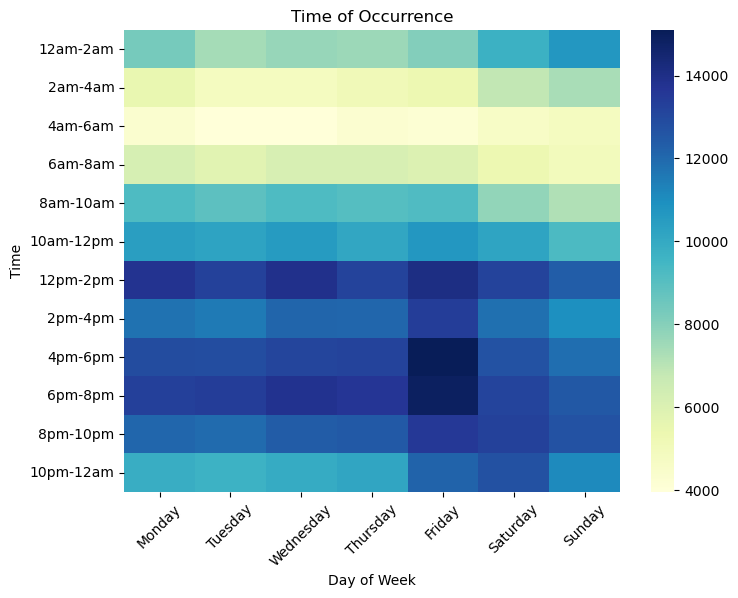

In [42]:
#Plot the heatmap to visualize the time of occurrence
import seaborn as sns
#Set the size of the figure
plt.figure(figsize=(8,6))

#Plot the heatmap
sns.heatmap(time_df,cmap='YlGnBu')

#Set the title, x and y labels
plt.title('Time of Occurrence')
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Time')
plt.show()


 ### 5.1.3 Answer

 - Comment:
     - According to the time of day, time from 2am to 4am has the smallest number of crimes .Meanwhile, time 12am to 2pm and 4pm to 8pm are the time when the number of criminals is most active.
     - Regarding weekdays, we see that Friday has a lot of criminal activity.

 - Conclusion:
     - Regarding early morning time, it can be explained simply by saying that at that time, the number of people going out is very small, so criminals do not have many opportunities to perform actions.
     - You can see, in the period from 4 to 8 pm, the number of crimes is extremely high, the explanation is because this is the time of the weekend just starting, so there are a lot of outside activities, crime. Access to more people. At the same time, everyone leaves the house more, creating more conditions for criminals to rob.


 ## 5.2 Do criminal groups operate depending on the season (cold or hot weather) ?

 ### 5.2.1 Meanings

 - Help people improvise to reduce the possibility of facing dangerous situations according to the seasons of the year.
 - If the results of this question differ between groups, this is an interesting result for everyone to understand better about *criminal psychology*.


 ### 5.2.2 How to answer questions

 - Firstly, let's find out what types of crimes happen the most.

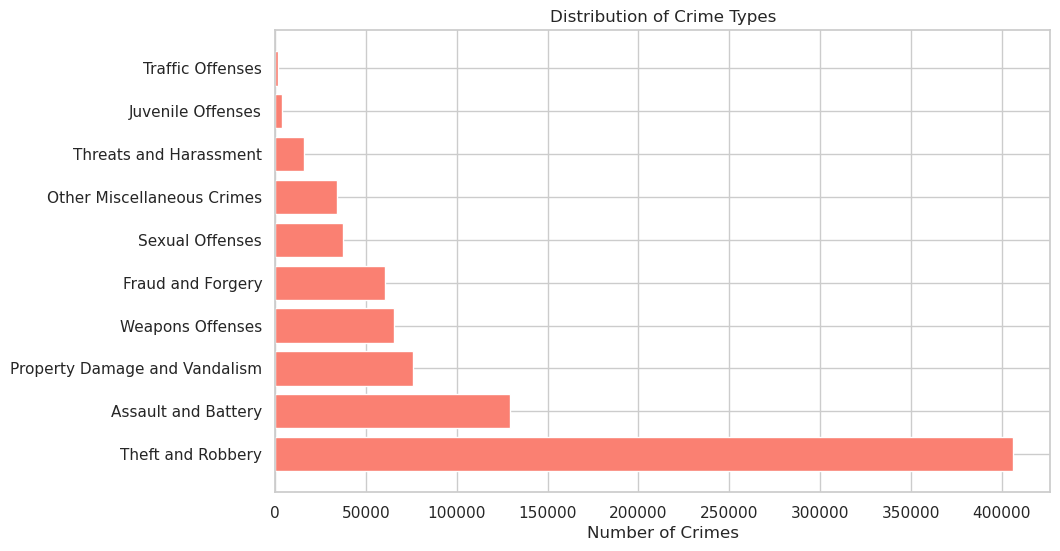

In [43]:
#Count the number of each type of crime
crime_counts = crime_df['crm_type'].value_counts()

#Sort the number of each type of crime
crime_counts = crime_counts.sort_values(ascending=False)

#Set style
sns.set(style="whitegrid")

#Set size of figure and plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(crime_counts.index, crime_counts, color='salmon')

#Set value of each ba

#Set title and label
plt.title('Distribution of Crime Types')
plt.xlabel('Number of Crimes')

#Save figure
plt.show()


 - Through this we can see that 3 types *Theft and Robbery*, *Assauld and Battery* and *Property Damage and Vandalism* are at the top in terms of the number of crimes that occur.
 - And these 3 crime groups can be groups that directly affect residents.
 - Therefore, the main analysis is Weaknesses for these three groups seem more useful to people in general and the city of Los Angeles in particular.

In [44]:
#Create a new dataframe to store important types of crime needed to this question
effect_president_col=['Theft and Robbery','Assault and Battery','Property Damage and Vandalism']
effect_president_crime_df=crime_df[crime_df['crm_type'].isin(effect_president_col)]


 - Secondly, we need to see what our data looks like for each year, is there any missing or oulier in a certain month?

/tmp/ipykernel_4038/1346331407.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file_path)


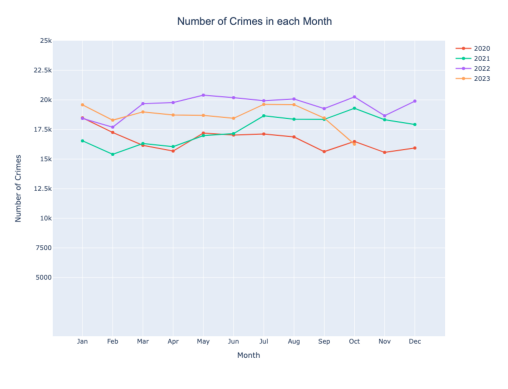

In [45]:
#Load image of the viaualization of the crime each month ,which is saved from the dashboard
import imageio

def plot_image_from_png(file_path):
    # Read image from file_path
    image = imageio.imread(file_path)

    # Plot the image
    plt.imshow(image)
    plt.axis('off')  # clear x- and y-axes
    plt.show()

# Đường dẫn đến file PNG của bạn
file_path = '../Data/Image/NumberOfCrimesEachMonth.png'
# Gọi hàm để plot ảnh
plot_image_from_png(file_path)



 - We can see that the year 2023 is missing November and December data. Maybe the agencies have not yet completed the report and added it to the dataset.
 - So we can delete the 2023 data so that the assessments will be accurate than.

In [46]:
#Just 2022 under 
effect_president_crime_df=effect_president_crime_df[effect_president_crime_df['datetime_occ'].dt.year<=2022]


In [47]:
#Change datetime_occ to month
def change_date_to_month(date):
    return date.month
effect_president_crime_df['datetime_occ']=effect_president_crime_df['datetime_occ'].apply(change_date_to_month)


In [48]:
#Create a new dataframe to store the number of each type of crime each month
temp_df=effect_president_crime_df.groupby(['datetime_occ','crm_type']).size().to_frame('count').reset_index()

#Create a new dataframe to store the average number of each type 
average_df=temp_df.groupby(['crm_type']).mean().reset_index().drop(['datetime_occ'],axis=1)


In [49]:
#create standard deviation dataframe by take count in each month of each type of 
#crime minus average of that type of crime and then divide by average of that type of crime
standard_deviation_df=temp_df.merge(average_df,on='crm_type')
standard_deviation_df.columns=['datetime_occ','crm_type','count','average']
standard_deviation_df['standard_deviation']=standard_deviation_df['count']-standard_deviation_df['average']

#Divide standard deviation by average and then multiply by 100 to get the percentage
standard_deviation_df['standard_deviation']=round((standard_deviation_df['standard_deviation']/standard_deviation_df['average'])*100,1)
standard_deviation_df=standard_deviation_df.drop(['count','average'],axis=1)



 - According to online sources, we can know that the cold season months in Los Angeles start from November to March (next month) and the hot season from May to October. We can draw more straight lines representing these two seasons by month to make it easier to visualize.


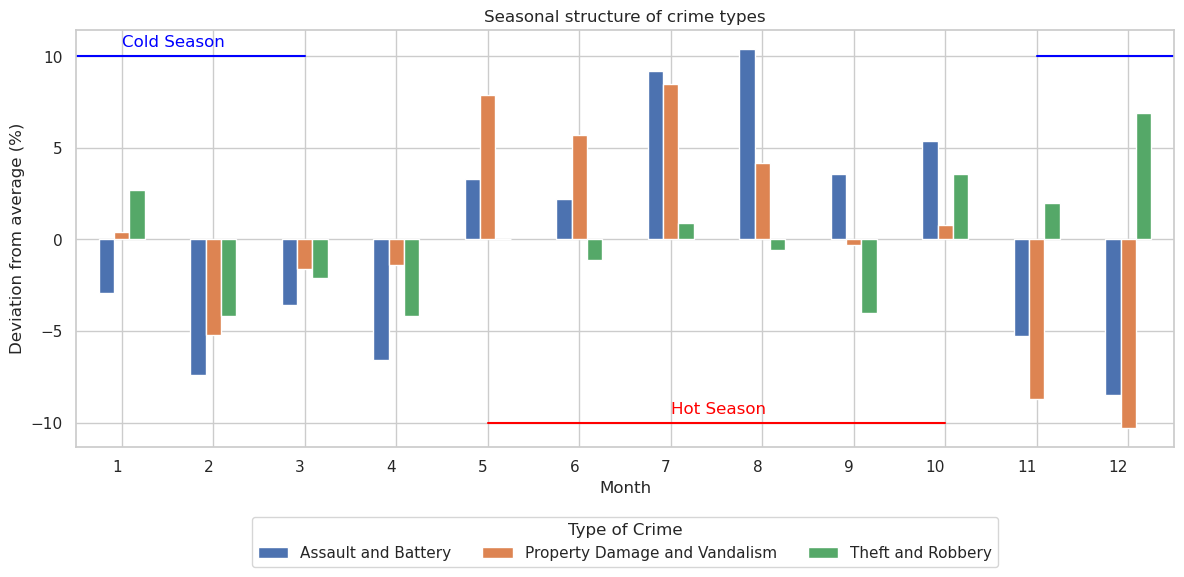

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Pivot the DataFrame to have each type_crime as a separate column
pivot_df = standard_deviation_df.pivot(index='datetime_occ', columns='crm_type', values='standard_deviation')

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each type_crime as a separate set of bars
pivot_df.plot(kind='bar', stacked=False, ax=ax)

#Plot hot and cold season
#value of x and y for hot and cold season is x-axis and y-axis of the plot not is the value of month
cold_season_1_x=[10,11.5]
cold_season_2_x=[-0.5,2]
cold_season_y=[10,10]
hot_season_1=[4,9]
hot_season_y=[-10,-10]
plt.plot(cold_season_1_x,cold_season_y,color='blue')
plt.plot(cold_season_2_x,cold_season_y,color='blue')
plt.plot(hot_season_1,hot_season_y,color='red')


# Add labels and title for each line
plt.text( 6, -10+0.5, 'Hot Season', color='red')
plt.text( 0, 10+0.5, 'Cold Season', color='blue')



# Add labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Deviation from average (%)')
ax.set_title('Seasonal structure of crime types')
# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='right')
# Show the legend
plt.legend(title='Type of Crime',loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Show the plot
plt.tight_layout()
plt.show()



### 5.2.3 Answer

 - Comment:
     - Overall, crime groups saw a decrease in incidents from February to April.
     - As for the *Assault and Battery* and *Property Damage and Vasndalism* groups, criminals prefer to operate from May to October.This is also a hot time of year in Los Angeles.
     - The *Theft and Robbery* group prefers to operate from October to January of the next year.This is also a cold time of year in Los Angeles.
 - Conclusion:
     - The fact that crime groups *Assault and Battery* and *Property Damage and Vasndalism* are high in the hot season can be explained by the fact that this is the summer vacation where many community activities take place, so criminals who commit crimes and crimes have many opportunities to approach criminals. more target audience.
     - In the cold season, more types of robberies occur because the cold season can have very limited passersby on the streets, so criminals have many opportunities to commit theft without being detected.



## 5.3 In 2023, where is the primary location for the usage of each weapon category?

### 5.3.1 Meanings
- Assist in enhancing people's comprehension of the weapon usage situation in Los Angeles.
- Help local law enforcement and security managers know where the weapon is most likely to be used and take measures to tighten security at that location.
- Visitors to these locations will become aware of the specific types of weapons they are most likely to encounter, enabling them to prepare for self-protection.

### 5.3.2 How to answer questions

In [51]:
df_2023=crime_df[crime_df['datetime_occ'].dt.year==2023]

- Firstly, we will categorize the weapon into 9 main categories: Firearm, Knife or Sharp Weapon, Drugs or Chemicals, Physical Presence, Blunt Object, Self Defense Weapon, Combustible, Vehicular, Animal
    - We have already categorized 80 weapon descriptions into 9 groups and stored the information in a JSON file. Our next step is to load the JSON file and associate each weapon description with its corresponding category.
    - For any NaN (Not a Number) values, we will assign them to the category "Unknown."

In [52]:
weapon_cat= json.load(open('../Data/weapon_cat.json', 'r'))
# Reverse the dictionary
weapon_cat_dict = {}
for key, value in weapon_cat.items():
    for v in value:
        weapon_cat_dict[v] = key

df_2023['weapon_cat'] = df_2023['weapon_desc'].map(weapon_cat_dict)
df_2023.loc[df_2023['weapon_cat'].isna(), 'weapon_cat'] = 'Unknown'

/tmp/ipykernel_4038/4227093450.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['weapon_cat'] = df_2023['weapon_desc'].map(weapon_cat_dict)


- Upon examining the counts of each weapon category in 2023, it is evident that four categories stand out with the highest incidence of crimes: Firearm, Knife or Sharp Weapon, Blunt Object, and Physical Presence.
- These categories also align with commonly encountered weapons in the real world, prompting us to concentrate our attention on these four specific weapon categories.

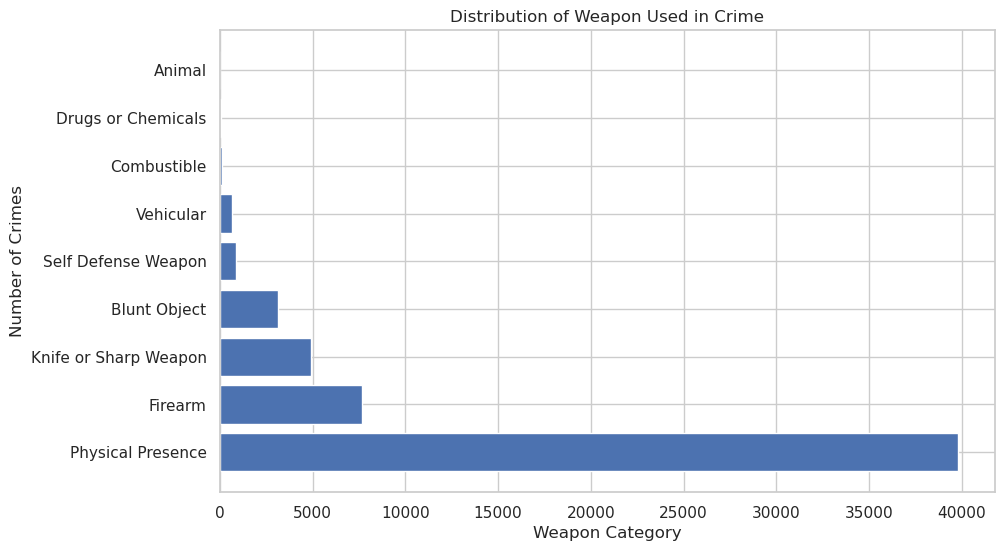

In [53]:
temp_df = df_2023[df_2023['weapon_cat'] != 'Unknown']
plt.figure(figsize=(10, 6))
plt.barh(temp_df['weapon_cat'].value_counts().index, temp_df['weapon_cat'].value_counts())
plt.title('Distribution of Weapon Used in Crime')
plt.xlabel('Weapon Category')
plt.ylabel('Number of Crimes')
plt.show()

- Using latitude and longitude, we create 4 scatter plots to visualize the location of each weapon category.

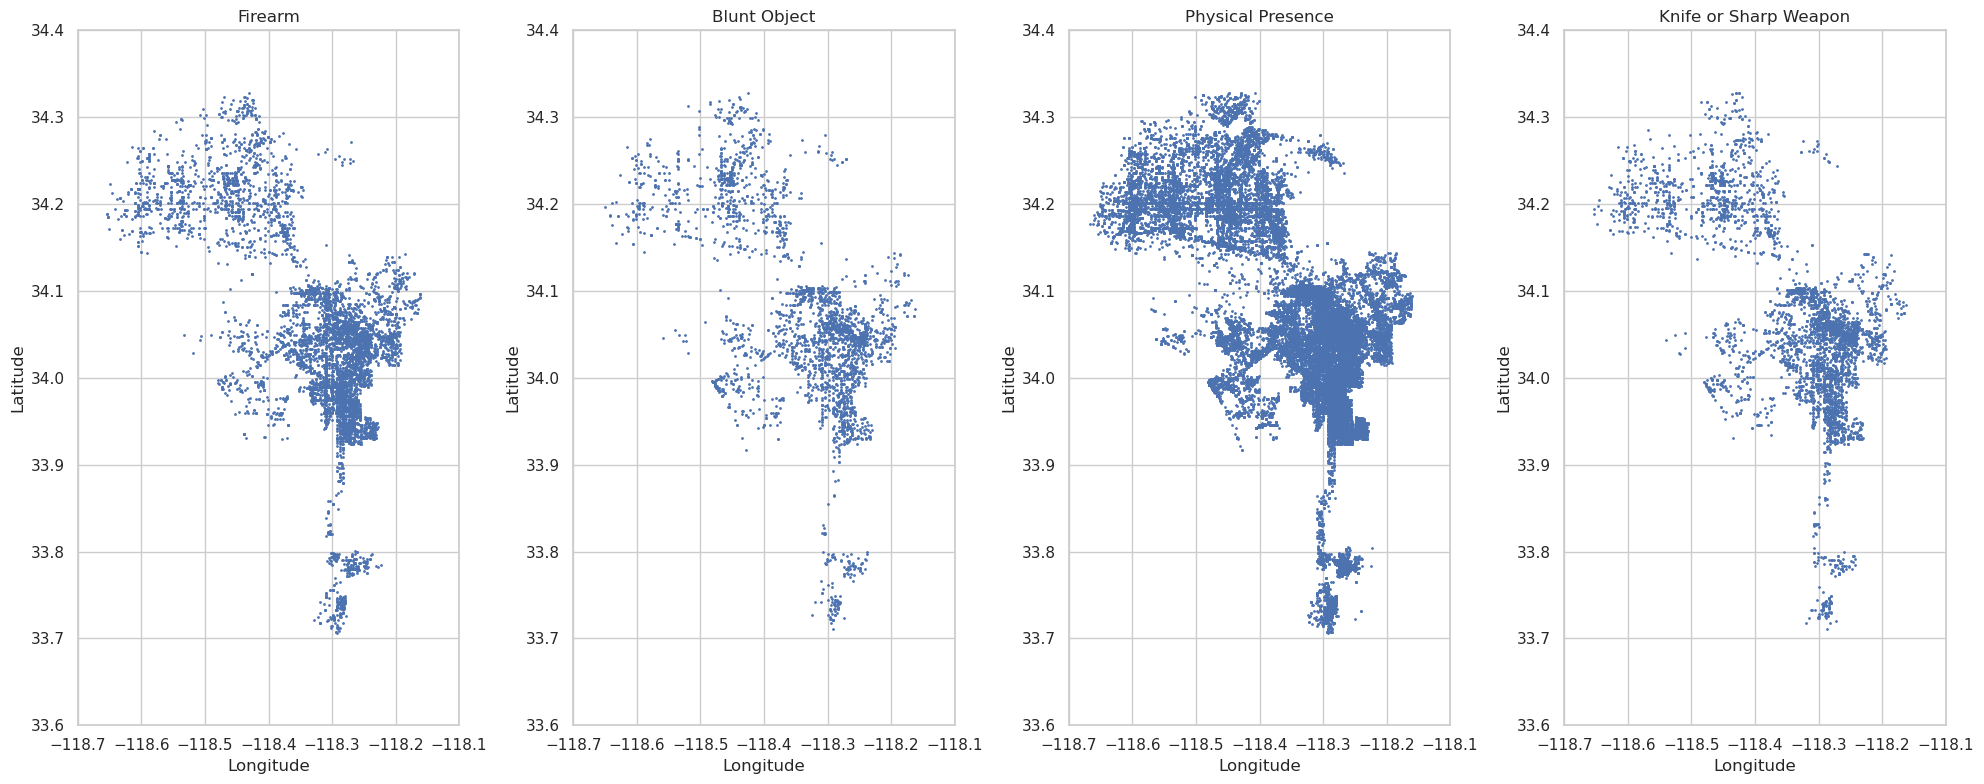

In [54]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8))
ax = ax.flatten()

temp_df = df_2023[df_2023['weapon_cat'].isin(['Physical Presence', 'Firearm', 'Knife or Sharp Weapon', 'Blunt Object'])]
temp_df = temp_df[temp_df['weapon_cat'].notna()]

for i, weapon in enumerate(temp_df['weapon_cat'].unique()):
    plot_df = temp_df[temp_df['weapon_cat'] == weapon]

    ax[i].scatter(plot_df['lon'], plot_df['lat'], s=1)  
    ax[i].set_title(weapon)
    ax[i].set_xlabel('Longitude') 
    ax[i].set_ylabel('Latitude')  
    ax[i].set_xlim(-118.7, -118.1)
    ax[i].set_ylim(33.6, 34.4)


plt.tight_layout()
plt.show()


### 5.3.3 Answer

- Comment:
    - Physical Presence emerges as the most prevalent weapon category, exhibiting widespread distribution throughout Los Angeles.
    - While the Blunt Object category is less common compared to the other three, it still maintains a broad presence across Los Angeles.
    - The two most perilous weapon categories, Firearm and Knife or Sharp Weapon, show a concentration in southern Los Angeles.
- Conclusion:
    - Southern Los Angeles, encompassing neighborhoods like Central, Hollywood, Wilshire, and others, stands out as an area with a significantly elevated prevalence of dangerous weapons. This occurrence could be attributed to the region being the most densely populated in Los Angeles, contributing to a complex crime landscape.
    - In contrast, other areas experience a lower frequency of dangerous weapon usage, although the overall numbers remain substantial.

## 5.4. If you were in Los Angeles, which crime would you encounter under a specific condition?

### 5.4.1. Meanings
- Prepare how to protect ourselves when going outside.
- Preventing going outside to minimize the risk of encountering crime, consider avoiding certain times and areas when venturing outside.

### 5.4.2. How to answer questions?

We have trained a `LGBMClassifier` model to predict the type of crime that might occur in Los Angeles under specific conditions. The model considers various factors, including location, victim demographics, and time of day.
The accuracy is about `0.79` (custom accuracy metric).

#### 5.4.2.1. Data preprocessing

The model utilizes the following features to make predictions:

- `area_name`: The name of the area where the crime occurred.
- `vict_age`: The age of the victim.
- `vict_sex`: The sex of the victim.
- `vict_descent`: The descent of the victim.
- `lat`: The latitude of the crime location.
- `lon`: The longitude of the crime location.
- `datetime_occ`: The date and time of the crime.

The `datetime_occ` column will be split into `year`, `month`, `day`, and `hour` columns, and then it will be dropped.

The model aims to predict the `crm_type`, which is a description of the crime code.

In [55]:
features = ['area_name', 'vict_age', 'vict_sex', 'vict_descent', 'lat', 'lon', 'datetime_occ']
target = 'crm_type'

clf_df = crime_df[crime_df['datetime_occ'].dt.year != 2023]

#### 5.4.2.1. Model training

A brief of training process we have done.

**Pipeline**

Creates a pipeline for data preprocessing and model fitting:
- Imputes missing categorical values with the most frequent values and encodes them using one-hot encoding.
- Imputes missing numerical values using KNNImputer.
- Uses LGBMClassifier as the model.

**Grid Search**

- Performs hyperparameter tuning using GridSearchCV to find the best model configuration.

**Final Model Training**

- Trains the model with the best hyperparameters on the entire training set.

**Evaluation**

- Defines a custom top-n accuracy metric.
- Evaluates model performance on the test set using this metric.

**Model Saving**

- Saves the trained model to a file named `model.joblib`.

#### 5.4.2.1. Make prediction

We will select a sample from the dataset to illustrate the model

In [60]:
X = clf_df[features].copy()
y = clf_df[target].copy()

X['year'] = X['datetime_occ'].dt.year
X['month'] = X['datetime_occ'].dt.month
X['day'] = X['datetime_occ'].dt.day
X['hour'] = X['datetime_occ'].dt.hour

X = X.drop(columns=['datetime_occ'])

In [ ]:
X_sample = X.sample(1)
y_sample = y[X_sample.index]
pd.concat([X_sample, y_sample], axis = 1)

,area_name,vict_age,vict_sex,vict_descent,lat,lon,year,month,day,hour,crm_type
341958,N Hollywood,61.0,M,W,34.1449,-118.4052,2021,3,19,10,Theft and Robbery


In [ ]:
model = joblib.load('../Model/model.joblib')
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['vict_age', 'lat', 'lon',
                                                   'year', 'month', 'day',
                                                   'hour']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['area_name', 'vict_sex',
                                                   'vict_descent'])])),
                ('classifier',
                 LGBMClassifier(boosting_type='dart', force_row_wise=True,
                                n_estimators=150, random_state=1))])

In [ ]:
prediction = model.predict_proba(X_sample)

In [ ]:
pd.DataFrame(prediction[0], index = model.classes_, columns = ['Probability']).sort_values(by = 'Probability', ascending = False)

,Probability
Theft and Robbery,0.492346
Fraud and Forgery,0.140137
Property Damage and Vandalism,0.097446
Assault and Battery,0.095093
Weapons Offenses,0.059663
Other Miscellaneous Crimes,0.056161
Sexual Offenses,0.040117
Threats and Harassment,0.016921
Juvenile Offenses,0.001059
Traffic Offenses,0.001059


 # 6. Conclusion
 - First of all, I would like to thank the teachers and readers for viewing the analyzes that the group has conducted recently. 
- Although most of the results are concluded based on basic statistical functions, not using machine learning models a lot. But the team also tried to ask good questions that are closely related to **criminal psychology**, through which readers can also have a more interesting perspective on criminals in general. general and crime in Angeles in particular.


- However, during the process, the team also encountered some common difficulties and difficulties in data processing :
    - Data has not been updated quickly: The team planned to carry out this project about 8 weeks ago. Although the team updates data continuously, data is still missing in November and December 2023. Causing problems If the results are inaccurate, it is necessary to develop a separate strategy for handling missing data for each issue.
    - The data has a lot of text columns and is quite interesting, for example `mocodes` that store behaviors and short descriptions of criminals and victims. However, the team does not have enough experience to process natural language. So we can't draw too many conclusions.
    - The data has many columns and rows of data, making it difficult to build models and run algorithms.
- Have learned:
    - Understand what steps the data science process goes through.
    - Learn how to effectively use **GitHub and Notion** for project management.
    - Improve effective teamwork skills and improve your ability to use English.
- What tasks will the team do if there is time?
    - Improve the current model and implement more highly applicable models.
    - Deploy the model and dashboard to the web.